In [1]:
exec(open("inc_notebook.py").read())

current working dirF:\myProjects\tfKeras\UCSC\CMPS242\earthquake


In [2]:
import logging, sys, math,os
exec(open("estimator/initKeras.py").read())

Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

if sys.modules.get( 'library.LivePlotKeras', False ) != False :
    del sys.modules['library.LivePlotKeras'] 
if sys.modules.get( 'LivePlotKeras', False ) != False :
    del sys.modules['LivePlotKeras'] 
from library.LivePlotKeras import *

logging.warning( "LivePlotKeras loaded" )

livePlotKeras = LivePlotKeras()

In [4]:
if sys.modules.get( 'estimator.EstimatorIO', False ) != False :
    del sys.modules['estimator.EstimatorIO'] 
if sys.modules.get( 'EstimatorIO', False ) != False :
    del sys.modules['EstimatorIO'] 
from estimator.EstimatorIO import *

logging.warning( "EstimatorIO loaded" )

estimatorIO = EstimatorIO()

In [5]:
from embedding.MultipleBinEmbeddingType import *

if sys.modules.get( 'library.MultipleBinDataGenerator', False ) != False :
    del sys.modules['library.MultipleBinDataGenerator'] 
if sys.modules.get( 'MultipleBinDataGenerator', False ) != False :
    del sys.modules['MultipleBinDataGenerator'] 
from library.MultipleBinDataGenerator import *

logging.warning( "MultipleBinDataGenerator loaded" )

trainGenerator = MultipleBinDataGenerator(embedding=MultipleBinEmbeddingType.CNN_STATS, 
                                          batch_size=32, windowSize = 36, stride = 6)

D:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:

model_input = layers.Input( shape = ( 36, 275, 1 ) )

#encoder
x = layers.Conv2D(64, kernel_size = (20,1), padding = 'same', activation=activations.relu)(model_input)
# x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(4,1), padding='same')(x)

x = layers.Conv2D(24, kernel_size=(10,1), activation=activations.relu, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(4,1), padding='same')(x)

x = layers.Conv2D(8, kernel_size=(5,1), activation=activations.relu, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(4,1), padding='same')(x)

#decoder
x = layers.Conv2D(8, kernel_size=(5,1), activation=activations.relu, padding='same')(x)
x = layers.UpSampling2D(size=(4,1))(x)

x = layers.Conv2D(24, kernel_size=(10,1), activation=activations.relu, padding='same')(x)
x = layers.UpSampling2D(size=(4,1))(x)

x = layers.Conv2D(64, kernel_size=(20,1), activation=activations.relu, padding='same')(x)
x = layers.UpSampling2D(size=(4,1))(x)

#estimator
x = layers.Conv2D(16, kernel_size=(5,1), activation=activations.relu, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(4,1), padding='same')(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)
# x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(1)(x)

model = models.Model(model_input, x, name = "1DCNN-Encoder-Decoder-Estimator-100epoch")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 36, 275, 1)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 36, 275, 64)       1344      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 275, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 9, 275, 24)        15384     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 275, 24)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 275, 8)         968       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 275, 8)         0         
__________

In [12]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
             loss = losses.MSE,
             metrics = [metrics.MSE, metrics.MAE])

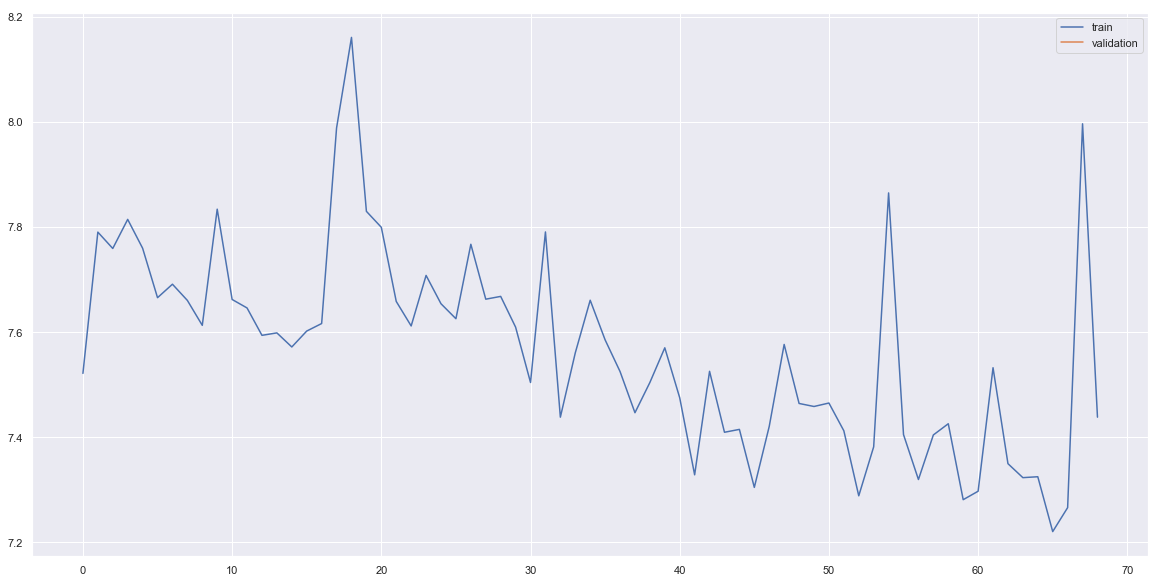

In [18]:
history = model.fit_generator( generator=trainGenerator,
                    use_multiprocessing=False, 
                    workers=3, 
                    initial_epoch = 31,
                    epochs=100,
                    max_q_size = 100,
                    steps_per_epoch = trainGenerator.getNumberOfBatches(),
                    callbacks = [livePlotKeras]
                   )

In [19]:
estimatorIO.save(model, model.name)

In [20]:
if sys.modules.get( 'library.EmbeddingStatsGeneratorForTestPos', False ) != False :
    del sys.modules['library.EmbeddingStatsGeneratorForTestPos'] 
if sys.modules.get( 'EmbeddingStatsGeneratorForTestPos', False ) != False :
    del sys.modules['EmbeddingStatsGeneratorForTestPos'] 
from library.EmbeddingStatsGeneratorForTestPos import *  
logging.warning( "EmbeddingStatsGeneratorForTestPos loaded" )

embeddingType = 'cnn-stats-test'
generator = EmbeddingStatsGeneratorForTestPos(embeddingType = embeddingType)

D:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [21]:
import pandas as pd
output = pd.read_csv('F:/myProjects/cmps242/earthquake/data/sample_submission.csv')
dic = {}
for testName, batch in generator.batchesByFile():
    print(f'test: {testName}')
#     print(trainModel.predict(batch, batch_size=generator.numberOfEmbeddingPerFile))
    pred = model.predict(batch, batch_size=generator.numberOfEmbeddingPerFile)
    dic[testName] = pred
#     print( output.index[output['seg_id'] == testName])
    output.at[output.index[output['seg_id'] == testName], 'time_to_failure'] = np.median(pred)

test: seg_00030f
test: seg_0012b5
test: seg_00184e
test: seg_003339
test: seg_0042cc
test: seg_004314
test: seg_004cd2
test: seg_004ee5
test: seg_004f1f
test: seg_00648a
test: seg_006e4a
test: seg_007a37
test: seg_00a37e
test: seg_00be11
test: seg_00c35b
test: seg_00cc91
test: seg_00e5f7
test: seg_00f3b9
test: seg_010eab
test: seg_0125d9
test: seg_0144cb
test: seg_0165c6
test: seg_016913
test: seg_016cdb
test: seg_017314
test: seg_01a8dc
test: seg_01c775
test: seg_01ecb0
test: seg_02042f
test: seg_025e78
test: seg_032822
test: seg_0339ca
test: seg_037461
test: seg_038879
test: seg_03d386
test: seg_03d63e
test: seg_03d680
test: seg_03f380
test: seg_0445d7
test: seg_046c28
test: seg_0488a1
test: seg_049957
test: seg_04a696
test: seg_04ae38
test: seg_04b87a
test: seg_04cceb
test: seg_04ee93
test: seg_04fd93
test: seg_0536c9
test: seg_055127
test: seg_05a1b0
test: seg_05a4ad
test: seg_05b66a
test: seg_05bef4
test: seg_05e0d7
test: seg_05f126
test: seg_05f9d6
test: seg_060ce4
test: seg_061a

test: seg_3065ba
test: seg_30661b
test: seg_306756
test: seg_30ad2a
test: seg_30b043
test: seg_30da11
test: seg_30fd84
test: seg_310230
test: seg_31064b
test: seg_311499
test: seg_311b5e
test: seg_3128e6
test: seg_3151ff
test: seg_31631c
test: seg_316f86
test: seg_318135
test: seg_31a51f
test: seg_31a6cd
test: seg_31b808
test: seg_31c0f4
test: seg_31d763
test: seg_31d7bf
test: seg_31d810
test: seg_31ddc5
test: seg_3234ca
test: seg_324447
test: seg_324537
test: seg_325790
test: seg_326eb7
test: seg_327ed4
test: seg_32906d
test: seg_32ad0f
test: seg_32c904
test: seg_32d747
test: seg_32e763
test: seg_32f3a9
test: seg_32f6df
test: seg_32f72d
test: seg_32fc4e
test: seg_330579
test: seg_3319b5
test: seg_331f2b
test: seg_3340b9
test: seg_335170
test: seg_337b8c
test: seg_339f80
test: seg_33c30d
test: seg_342ce6
test: seg_343571
test: seg_3452b2
test: seg_34a2b8
test: seg_34a8f7
test: seg_34abd2
test: seg_34ef79
test: seg_3506d6
test: seg_35269b
test: seg_355717
test: seg_355d19
test: seg_35a2

test: seg_62c582
test: seg_63130f
test: seg_633651
test: seg_634180
test: seg_634f05
test: seg_635770
test: seg_63582a
test: seg_63c13d
test: seg_63c518
test: seg_63c8e4
test: seg_63c983
test: seg_63c9a3
test: seg_63d651
test: seg_6422d1
test: seg_643d1f
test: seg_643f86
test: seg_64bcb9
test: seg_64be5d
test: seg_64be91
test: seg_64daae
test: seg_64dcf0
test: seg_64f8dc
test: seg_650de2
test: seg_651808
test: seg_652cc2
test: seg_655780
test: seg_655ad6
test: seg_655cae
test: seg_658bf4
test: seg_659ff8
test: seg_65b962
test: seg_65c4e1
test: seg_65ef95
test: seg_65f01e
test: seg_65fbac
test: seg_660fe1
test: seg_660fef
test: seg_661629
test: seg_666056
test: seg_6681ee
test: seg_66820a
test: seg_6696d0
test: seg_66b7c3
test: seg_66e45a
test: seg_66ed4d
test: seg_670bde
test: seg_67330f
test: seg_673c60
test: seg_67599b
test: seg_679dd2
test: seg_67aa76
test: seg_68102c
test: seg_683ddf
test: seg_686edc
test: seg_687a5c
test: seg_68a484
test: seg_68da94
test: seg_691a72
test: seg_692e

test: seg_91cff2
test: seg_91eaeb
test: seg_91f512
test: seg_91f664
test: seg_91fc29
test: seg_920132
test: seg_92092a
test: seg_922914
test: seg_922990
test: seg_92310f
test: seg_929ded
test: seg_92a5f1
test: seg_92af10
test: seg_92b095
test: seg_92bd37
test: seg_92be9f
test: seg_931244
test: seg_93211c
test: seg_932828
test: seg_934087
test: seg_939f5c
test: seg_93d864
test: seg_93f935
test: seg_941759
test: seg_943de0
test: seg_944c98
test: seg_945bc8
test: seg_946d71
test: seg_946d9a
test: seg_947700
test: seg_9485c0
test: seg_94a133
test: seg_94aa0a
test: seg_94c48c
test: seg_94d150
test: seg_94d573
test: seg_94ecad
test: seg_950048
test: seg_952faa
test: seg_95357d
test: seg_95644e
test: seg_957ece
test: seg_95b321
test: seg_95f45e
test: seg_961d02
test: seg_961ddf
test: seg_9626a4
test: seg_96642e
test: seg_966f3d
test: seg_967ae4
test: seg_96cd5d
test: seg_96dab2
test: seg_96db5e
test: seg_96fa35
test: seg_970b35
test: seg_970e86
test: seg_974049
test: seg_9757ac
test: seg_979a

test: seg_bf1294
test: seg_bf1430
test: seg_bf1a72
test: seg_bf2d1f
test: seg_bf4bf2
test: seg_bf4ec0
test: seg_bf58ce
test: seg_bf7224
test: seg_bfdd14
test: seg_bfe0b6
test: seg_bff05e
test: seg_bff392
test: seg_c01a57
test: seg_c01d9a
test: seg_c01f63
test: seg_c0260d
test: seg_c047b7
test: seg_c05a7d
test: seg_c07b7c
test: seg_c08d36
test: seg_c09a41
test: seg_c0c0ed
test: seg_c0d7da
test: seg_c0e1b9
test: seg_c0ea9f
test: seg_c106ca
test: seg_c10a58
test: seg_c11828
test: seg_c11a4f
test: seg_c12d7d
test: seg_c146a8
test: seg_c15d21
test: seg_c17817
test: seg_c179f8
test: seg_c183e4
test: seg_c186dc
test: seg_c18d5a
test: seg_c1fe9a
test: seg_c20a27
test: seg_c20c06
test: seg_c21723
test: seg_c21d60
test: seg_c22bd4
test: seg_c23429
test: seg_c23641
test: seg_c243a6
test: seg_c24946
test: seg_c25855
test: seg_c267a5
test: seg_c26fb4
test: seg_c27591
test: seg_c2a0c8
test: seg_c2b8f7
test: seg_c3507f
test: seg_c35940
test: seg_c365de
test: seg_c3836b
test: seg_c3f672
test: seg_c3f8

test: seg_eb692c
test: seg_eb7595
test: seg_eb7f91
test: seg_eba22d
test: seg_ebb79f
test: seg_ebd77b
test: seg_ebe36c
test: seg_ebec3e
test: seg_ec0e7b
test: seg_ec4645
test: seg_ec73d5
test: seg_ec973c
test: seg_eca2eb
test: seg_ecaef0
test: seg_eccb17
test: seg_ecdca4
test: seg_ecf28d
test: seg_ecf81b
test: seg_ed07b0
test: seg_ed3e4c
test: seg_ed52ac
test: seg_ed7741
test: seg_ed7dee
test: seg_ed7f69
test: seg_edda79
test: seg_edecaa
test: seg_ee1cfc
test: seg_ee2781
test: seg_ee4479
test: seg_ee4ae5
test: seg_ee7224
test: seg_ee87e2
test: seg_ee8f87
test: seg_eea20e
test: seg_eebbc2
test: seg_eee89d
test: seg_eefd4a
test: seg_ef24bd
test: seg_ef27c8
test: seg_ef47c4
test: seg_ef644a
test: seg_ef660a
test: seg_ef74dc
test: seg_ef779d
test: seg_ef9105
test: seg_efb639
test: seg_efbf3e
test: seg_efc5fb
test: seg_efd9ec
test: seg_f003ca
test: seg_f01368
test: seg_f0181d
test: seg_f02d32
test: seg_f056d8
test: seg_f0574b
test: seg_f073e2
test: seg_f0ce4a
test: seg_f0cedb
test: seg_f0d2

test: seg_ff7478
test: seg_ff79d9
test: seg_ffbd6a
test: seg_ffe7cc


In [22]:
output.to_csv(f'F:/myProjects/cmps242/earthquake/data/{model.name}.csv', index=False)